In [1]:
''' 
 Author: Yoonhyuck WOO / JBNU_Industrial Information system Engineering
 Date; 10. 15. 2021 - 10. . 2021
 Title: Pytorch tutorial: Follow [Text] part code
 Professor: Seung-Hoon Na
 Reference: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html'''

' \n Author: Yoonhyuck WOO / JBNU_Industrial Information system Engineering\n Date; 10. 15. 2021 - 10. . 2021\n Title: Pytorch tutorial: Follow [Text] part code\n Professor: Seung-Hoon Na\n Reference: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html'

In [3]:
print(all_categories) #index ~ 17

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


# Creating the Network

In [4]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1) # 1 => horizontally / 0 => vertically
        hidden = self.i2h(input_combined) # size: input_combined X hidden_size 
        output = self.i2o(input_combined) # size: input_combined X output_size
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
        '''
        ex
        m = nn.Linear(20, 30) 
        input = torch.randn(128, 20) 
        output = m(input) 
        print(output.size())
        torch.Size([128, 30])
        '''
    # For every epoch, we should re-initialize a new beginner hidden state, 
    # because during the testing, our model will have no information about the test sentence and will have a zero initial hidden state.    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training

# Preparing for Training
- helper functions to get random pairs of (category, line)

In [5]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    '''
    all category: ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 
                   'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
    '''
    line = randomChoice(category_lines[category])
    return category, line

randomTrainingPair()

('Scottish', 'Sutherland')

# For each timestep (== for each letter in a training word) 
- the inputs of the network: (category, current letter, hidden state)
- the outputs:               (next letter, next hidden state). 
- So for each training set, need the category, a set of input letters, and a set of output/target letters.

- predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line
- e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”)

category tensor: one-hot tensor of size <1 x n_categories>. 

When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [6]:
# One - hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories) # (1, 18)
    tensor[0][li] = 1
    return tensor

# One - hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) # (line, 1, 57)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [7]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# Training the Network
- making a prediction at every step
- calculating loss at every step
- autograd: sum these losses at each step and call backward at the end

In [8]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
        loss.backward()
        
        for p in rnn.parameters():
            p.data.add_(p.grad.data, alpha = - learning_rate)
        return output, loss.item() / input_line_tensor.size(0)

In [9]:
# To keep track of how long training takes I am adding a timeSince(timestamp) function which returns a human readable string:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m,s)

In [10]:
# Call train a bunch of times and wait a few minutes, printing the current time and loss every print_every examples
# Keeping store of an average loss per plot_every examples in all_losses for plotting later.

In [11]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter %  print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 5s (5000 5%) 0.6199
0m 10s (10000 10%) 1.1017
0m 15s (15000 15%) 1.5697
0m 20s (20000 20%) 0.3628
0m 25s (25000 25%) 0.6329
0m 30s (30000 30%) 0.1618
0m 35s (35000 35%) 0.4784
0m 40s (40000 40%) 0.1375
0m 44s (45000 45%) 0.2992
0m 49s (50000 50%) 0.6929
0m 54s (55000 55%) 0.5085
0m 59s (60000 60%) 0.2590
1m 3s (65000 65%) 0.7968
1m 8s (70000 70%) 0.1769
1m 13s (75000 75%) 0.3218
1m 19s (80000 80%) 0.3774
1m 23s (85000 85%) 0.4617
1m 28s (90000 90%) 0.4879
1m 33s (95000 95%) 0.4239
1m 38s (100000 100%) 0.6891


# Plotting the Losses

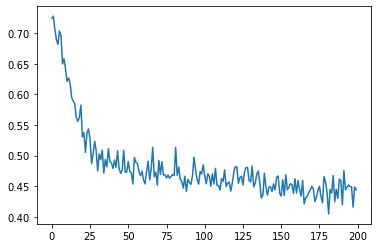

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)

# Sampling the Network

In [26]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter = 'A'):
    with torch.no_grad(): # no need to track histroy in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1: 
                break
            else:
                letter = all_letters[topi]
                output_name += letter
        input = inputTensor(letter)
            
        return output_name
    
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters = 'ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        
samples('Korean','KOR')
samples('Russian', 'RUS')

Koooaooaoooaoooaooooo
Oohouoooooooooooooooo
Roooooiiooooooooooooi
Roooaooooooaooooooaoo
Uaaaiaaaaaaaaaaaaaaaa
Saaaahhaaaaaaaaaaahaa
